# Predicting the Success of Bank Telemarketing

DSCI 632  
Atheer Albarqi  
Xi Chen  
Emily Wang  

## 1. Introduction

Companies often conduct marketing campaigns to attract new customers and grow their business. Direct marketing is used by businesses to reach certain categories of customers to meet specific goals. One of the most widely used campaign channel is the telephone, which is called telemarketing. This project focuses on telemarketing phone calls to sell long-term deposits. Within a campaign, the human agents execute phone calls to a list of clients to sell the deposit (outbound), or, if the client calls the contact center for any other reason, they are asked to subscribe to the deposit (inbound).

Technology can allow companies to rethink marketing through the analysis of data to build longer and tighter relations in line with company needs. Machine learning techniques can therefore be used to support managerial decision making.

## 2. Objective

In this project, we will develop classification algorithm that can automatically predict the results of a phone call to sell long term deposits by using a machine learning approach.

## 3. Potential Users and Applications

The results from the machine learning model would be valuable for managers in making decisions on prioritizing and selecting the next customers to be contacted during future marketing campaigns. For instance, the probability of success of the current campaign can help the business decide how many customers to contact in the next campaign, making the campaigns more effective and reducing the time and costs of such campaigns.

## 4. Related Work

This study is inspired by the research paper by Moro et al., where the researchers used a similar dataset to determine the success of bank telemarketing in selling bank long-term deposits.

Another inspiration is the project by Palaniappan et al., whose aim is to help banks increase their accuracy of customer profiling through classification as well as to identify a high probability group of customers to subscribe to a long-term deposit.

## 5. Dataset and Methods

### 5.1. Dataset

The dataset is published by UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/bank+marketing). It contains real data related with direct marketing campaigns (phone calls) of a Portuguese banking institution from May 2008 to June 2013. Often, more than one contact to the same client was required to assess whether the product (bank term deposit) would be subscribed. There are 41,188 examples in the dataset and 21 attributes.

### 5.2 Methods

In this work, we will test three binary classification models as implemented in PySpark. All data processing and analysis will be done in the PySpark environment. The classification models we will test are:
1. __Logistic Regression__

  LR is a popular choice in credit scoring because it utilizes a smooth nonlinear logistic transformation over a multiple regression model to estimate class probabilities.
2. __Decision Tree__

  The DT is a branching structure that represents a set of rules, distinguishing values in a hierarchical form. This representation can be translated into a set of IF–THEN rules, which are easy to understand by humans.

## 6. Exploratory Data Analysis

### Run pyspark in Google Colab

In [1]:
# Code needed to set up the PySpark Environment in Google Colab

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar xvf spark-3.0.3-bin-hadoop2.7.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
!pip install -q findspark
!pip install pyspark==3.0.3
from google.colab import drive
drive.mount('/content/gdrive')

spark-3.0.3-bin-hadoop2.7/
spark-3.0.3-bin-hadoop2.7/NOTICE
spark-3.0.3-bin-hadoop2.7/kubernetes/
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/worker_memory_check.py
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/py_container_checks.py
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/pyfiles.py
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/entrypoint.sh
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/R/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/R/Dockerfile
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/python/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/python/Dockerfile
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/Dockerfile
spark-3.0.3-bin-hadoop2.7/jars/
spark-3.0.3-bin-hadoop2.7/jars/jacks

#### Set up PySpark Spark Session

In [2]:
import pyspark 
from pyspark.sql import SparkSession

APP_NAME = "FinalProject"
SPARK_URL = "local[*]"

spark = SparkSession.builder.appName(APP_NAME).getOrCreate()

from pyspark import SparkContext

sc = SparkContext.getOrCreate(spark)

#### Import Libraries

In [20]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, VectorAssembler
import matplotlib.pyplot as plt 
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import confusion_matrix , classification_report
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import numpy as np
import seaborn as sns


In [21]:
# Read the file and view the first few rows

df = spark.read.load('bank-additional-full.csv', format="csv", sep=";", inferSchema="true", header="true")
df.show(5)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 37| serv

Input variables:
### bank client data:
1 - age (numeric)  
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')  
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)  
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')  
5 - default: has credit in default? (categorical: 'no','yes','unknown')  
6 - housing: has housing loan? (categorical: 'no','yes','unknown')  
7 - loan: has personal loan? (categorical: 'no','yes','unknown')  
### related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')  
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')  
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')  
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.  
### other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)  
14 - previous: number of contacts performed before this campaign and for this client (numeric)  
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')  
### social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)  
17 - cons.price.idx: consumer price index - monthly indicator (numeric)  
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)  
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)  
20 - nr.employed: number of employees - quarterly indicator (numeric)  

###Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [22]:
# Inspect data types of attributes

df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('month', 'string'),
 ('day_of_week', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('emp.var.rate', 'double'),
 ('cons.price.idx', 'double'),
 ('cons.conf.idx', 'double'),
 ('euribor3m', 'double'),
 ('nr.employed', 'double'),
 ('y', 'string')]

In [23]:
# See dataframe dimensions

[df.count(), len(df.columns)]

[41188, 21]

In [24]:
# Renaming some columns because the original names with "." were causing errors

cols_to_rename = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'nr.employed']
for col_name in cols_to_rename:
  new_name = '_'.join(col_name.split('.'))
  df = df.withColumnRenamed(col_name, new_name)

In [25]:
# Missing value check

df_nona = df.na.drop()
df_nona.count()

41188

Fortunately, there are no missing values.

There are many variables that determine whether a marketing campaign will be successful or not. Today, these variables are know as the marketing mix theory, which is also referred to as the 4Ps, i.e. product, price, promotion “communication”, and place “distribution” (McCarthy, 1971 - McCarthy, J.E. (1971), Basic Marketing: A Managerial Approach, Richard D. Irwin, Homewood, IL.). These marketing mix elements are the four key decision areas that must be managed to work together in a single marketing plan to satisfy customer needs better than the competition and allow the firm to make a reasonable profit (https://www.emerald.com/insight/content/doi/10.1108/07363760710756011/full/html?casa_token=PsXSi6YaI0EAAAAA:j_LSyzxTMQK6W7pBr2ufh5sEppYiyyS3MOUZIguSaKisCaq1Q5DG10VpLwcebUXkSRwx3rk9irf4ViHflCzmy45eUqvKocDCxH-CbwzQ20gbnrflag).

Not all four of the elemebnts above apply the our dataset. Therefore, for the exploratory data analysis, we will focus on two elements from a modified version of the marketing mix: 
1. Population
- Which segment of the population is the marketing campaign going to address and why? 
- What is the demographic distribution among the clients (age, job, marital status, education)? 
- Bsed on this dataset, are older people more likely so subscribe to term deposists?
2. Place: 
- Which distribution channel is the most effective (telephone, cellular)?

### Target Variable EDA

__How many clients have subscribed to the term deposit?__

The figure below shows that most clients (88.7%) do not subscribe.

In [26]:
# Inspect the distribution of the target variable y

target_features = ['y']
normalize = udf(lambda x: x/sum)

for feature in target_features:
  counts = df.groupBy(feature).count()
  sum = counts.agg({'count':'sum'}).collect()[0][0]
  counts.withColumn('percentage', normalize(counts['count'])).show()

+---+-----+-------------------+
|  y|count|         percentage|
+---+-----+-------------------+
| no|36548| 0.8873458288821987|
|yes| 4640|0.11265417111780131|
+---+-----+-------------------+



As we can see the dataset is __highly imbalanced__. Oversampling or undersampling needs to be done to have a balanced dataset.

### Numerical Features EDA

In [27]:
# See statistical distribution of the values in each column

df.summary().show()

+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+------------------+------------------+-----------------+-------------------+--------+-------------------+------------------+------------------+------------------+-----------------+-----+
|summary|               age|    job| marital|education|default|housing| loan|  contact|month|day_of_week|          duration|          campaign|            pdays|           previous|poutcome|       emp_var_rate|    cons_price_idx|     cons_conf_idx|         euribor3m|      nr_employed|    y|
+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+------------------+------------------+-----------------+-------------------+--------+-------------------+------------------+------------------+------------------+-----------------+-----+
|  count|             41188|  41188|   41188|    41188|  41188|  41188|41188|    41188|41188|      41188|             41188|

#### Summary:

Mean Age is aproximately 40 years old. (Minimum: 17 years old and Maximum: 98 years old.)

From the distribution, we can see that three features are highly skewed to the right: 
- age
- campaign
- previous

The  fact  that  the  maximum  age  is  almost three  times  the  the  median  age  shows  that  the  distribution of  age  is  heavily  skewed  to  the  right.  Therefore,  logarithmic transformation  will  need  to  be  applied  to  the  age  column  to normalize the distribution of the feature. Same with the other two skewed features.

#### Log Transformation
Note that duration highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should be **discarded** to have a realistic predictive model.

__What is the age distribution among the clients__

Most are between 20 and 50.

### Log transformation

In [28]:
# Apply log transformation on select columns

cols_to_transform = ['age', 'campaign', 'previous']
log_transform = udf(lambda x: float(np.log10(float(x+1e-16))), FloatType())

for col in cols_to_transform:
    new_col = col+'_log'
    df = df.withColumn(new_col, log_transform(df[col]))

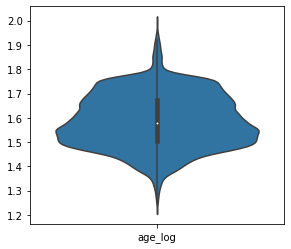

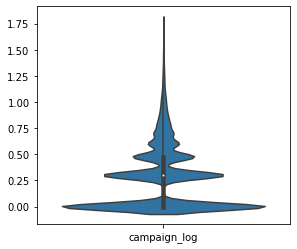

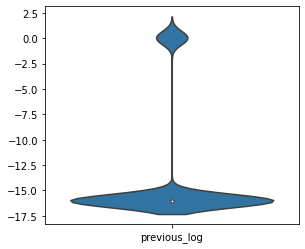

In [29]:
log_features = ['age_log', 'campaign_log', 'previous_log']

for feature in log_features:
    x = df.select(feature).toPandas()
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 2, 2)
    ax = sns.violinplot(data=x)

### Categorical Features EDA

__What is the demographic distribution among the clients (age, job, marital status, education)?__

The figure below shows the distribution of categorical variables including demographic information. A lot of clients have adminstrative jobs, are married, and have a university degree.

In [30]:
# Inspect the distribution of categorical features

cat_features = ['job','marital','education','default','housing','loan','contact','month','day_of_week']
normalize = udf(lambda x: x/sum)

for feature in cat_features:
  counts = df.groupBy(feature).count()
  sum = counts.agg({'count':'sum'}).collect()[0][0]
  counts.withColumn('percentage', normalize(counts['count'])).show()


+-------------+-----+--------------------+
|          job|count|          percentage|
+-------------+-----+--------------------+
|   management| 2924| 0.07099155093716616|
|      retired| 1720| 0.04175973584539186|
|      unknown|  330|0.008012042342429833|
|self-employed| 1421| 0.03450033990482665|
|      student|  875| 0.02124405166553365|
|  blue-collar| 9254|  0.2246770904146839|
| entrepreneur| 1456| 0.03535010197144799|
|       admin.|10422| 0.25303486452364765|
|   technician| 6743|  0.1637127318636496|
|     services| 3969| 0.09636301835486064|
|    housemaid| 1060|0.025735651160532193|
|   unemployed| 1014|0.024618821015829854|
+-------------+-----+--------------------+

+--------+-----+--------------------+
| marital|count|          percentage|
+--------+-----+--------------------+
| unknown|   80|0.001942313295134...|
|divorced| 4612| 0.11197436146450422|
| married|24928|  0.6052248227639119|
|  single|11568| 0.28085850247644945|
+--------+-----+--------------------+

+-----

__Based on this dataset, what customers are more likely so subscribe to term deposists?__

Text(3.799999999999997, 0.5, 'Age')

<Figure size 1080x360 with 0 Axes>

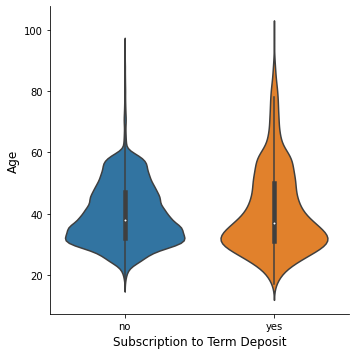

In [31]:
# Plot age with target variable

x = df.select(['age', 'y']).toPandas()
plt.figure(figsize=(15, 5))
sns.catplot(x='y', y='age', data=x, kind='violin')
#sns.set(rc={'figure.figsize':(15.7,8.27)})
plt.xlabel('Subscription to Term Deposit', fontsize=12)
plt.ylabel('Age', fontsize=12)


People over the age of 60 are more likely to subscribe to term deposits.

__What aer the top 5 demographics that subscribe to the term deposit?__

In [32]:
counts = df.groupBy('job', 'marital','education', 'y').count()
counts.filter(counts['y']=='yes').orderBy(['count'], ascending=[0,1]).show(5)

+----------+-------+-------------------+---+-----+
|       job|marital|          education|  y|count|
+----------+-------+-------------------+---+-----+
|    admin.|married|  university.degree|yes|  386|
|    admin.| single|  university.degree|yes|  360|
|technician|married|professional.course|yes|  196|
|    admin.|married|        high.school|yes|  175|
|management|married|  university.degree|yes|  169|
+----------+-------+-------------------+---+-----+
only showing top 5 rows



__Which contact method (cellular vs telephone) is more successful?__

In [33]:
df.crosstab('contact', 'y').show()

+---------+-----+----+
|contact_y|   no| yes|
+---------+-----+----+
| cellular|22291|3853|
|telephone|14257| 787|
+---------+-----+----+



In [34]:
print(f"Success rate of cellular campaigns: {3853/(22291+3853)}")
print(f"Success rate of telephone campaigns: {787/(14257+787)}")

Success rate of cellular campaigns: 0.14737607099143207
Success rate of telephone campaigns: 0.05231321457059293


## 7. Data Pre-Processing

### Dropping duration

In [35]:
df = df.drop('duration')

### Label Encoding and Vector Assembly

In [36]:
# Label encoding for categorical variables

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, VectorAssembler

cols=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome','y']

stages = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in cols]
pipeline = Pipeline(stages=stages)
df_encoded = pipeline.fit(df).transform(df)

df_encoded = df_encoded.drop('job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome','y')

df_encoded.show(5)

+---+--------+-----+--------+------------+--------------+-------------+---------+-----------+---------+------------+------------+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+-------+
|age|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  age_log|campaign_log|previous_log|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index|y_index|
+---+--------+-----+--------+------------+--------------+-------------+---------+-----------+---------+------------+------------+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+-------+
| 56|       1|  999|       0|         1.1|        93.994|        -36.4|    4.857|     5191.0| 1.748188|         0.0|       -16.0|      8.0|          0.0|            4.0|   

In [37]:
feature_cols = [x for x in df_encoded.columns if x != 'y_index']

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df_transformed = assembler.transform(df_encoded)

df_transformed.show(5)

+---+--------+-----+--------+------------+--------------+-------------+---------+-----------+---------+------------+------------+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+-------+--------------------+
|age|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  age_log|campaign_log|previous_log|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index|y_index|            features|
+---+--------+-----+--------+------------+--------------+-------------+---------+-----------+---------+------------+------------+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+-------+--------------------+
| 56|       1|  999|       0|         1.1|        93.994|        -36.4|    4.857|     5191.0| 1.748188|      

In [38]:
indexer = StringIndexer(inputCol='y_index', outputCol='label')
index_model = indexer.fit(df_transformed)
vec_df = index_model.transform(df_transformed).select("features", "label")

vec_df.show(5, truncate = False)

+-----------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                               |label|
+-----------------------------------------------------------------------------------------------------------------------+-----+
|[56.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.7481880187988281,0.0,-16.0,8.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0]|0.0  |
|[57.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.7558748722076416,0.0,-16.0,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0]|0.0  |
|[37.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.5682017803192139,0.0,-16.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0]|0.0  |
|[40.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.6020599603652954,0.0,-16.0,0.0,0.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0]|0.0  |
|[56.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.7481880187988281,0.0,-16.0,3.0,0.0,1.0,0.0,1.0,1.0,

### Check Correlation Between Features

In [39]:
from pyspark.ml.stat import Correlation

matrix = Correlation.corr(vec_df, "features")
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()
cor_np

array([[ 1.00000000e+00,  4.59358049e-03, -3.43689512e-02,
         2.43647409e-02, -3.70685467e-04,  8.56714971e-04,
         1.29371614e-01,  1.07674295e-02, -1.77251319e-02,
         9.86683016e-01,  1.30529547e-04,  1.66022192e-02,
         1.04522264e-01, -1.14982628e-01,  1.82827026e-01,
         1.64965292e-01,  9.87060453e-04, -6.39657215e-03,
         7.02094777e-03,  9.31100080e-02,  1.61885680e-02,
         2.63708274e-02],
       [ 4.59358049e-03,  1.00000000e+00,  5.25835734e-02,
        -7.91414724e-02,  1.50753806e-01,  1.27835912e-01,
        -1.37330987e-02,  1.35132511e-01,  1.44094895e-01,
         8.63753353e-03,  8.56819160e-01, -8.76852606e-02,
        -1.33017937e-02,  2.26926911e-03,  2.76672608e-03,
         3.28245362e-02,  9.76839994e-03,  3.89909909e-03,
         7.73675370e-02, -6.75018981e-02,  6.40299937e-04,
        -8.60833124e-02],
       [-3.43689512e-02,  5.25835734e-02,  1.00000000e+00,
        -5.87513856e-01,  2.71004174e-01,  7.88891087e-02,
    

In [40]:
# Check if any values are too high

def check_binarizer(matrix):
  bin_matrix = matrix.copy()
  for i in range(len(matrix)):
    for j in range(len(matrix)):
      if 0.85 < matrix[i][j] < 1: 
        # 0.85 is an artitrary threshold
        bin_matrix[i][j] = int(1)
      else:
        bin_matrix[i][j] = int(0)
  return bin_matrix

In [41]:
# Get indices of high correlation

bin_matrix = check_binarizer(cor_np)
high_corr = np.where(bin_matrix == 1)
high_corr

(array([ 0,  1,  3,  3,  4,  4,  7,  7,  8,  8,  9, 10, 11, 11, 21, 21]),
 array([ 9, 10, 11, 21,  7,  8,  4,  8,  4,  7,  0,  1,  3, 21,  3, 11]))

In [42]:
# Mapping the indices back to feature names

high_corr_cols = np.array(high_corr).copy()
high_corr_cols = [str(a) for a in high_corr_cols]
high_corr_cols[0] = [str(i) + '_' + str(high_corr[0][i]) + '_'+ df_transformed.columns[high_corr[0][i]] for i in range(len(high_corr[0]))]
high_corr_cols[1] = [str(i) + '_' + str(high_corr[1][i]) + '_'+ df_transformed.columns[high_corr[1][i]] for i in range(len(high_corr[1]))]
high_corr_cols

[['0_0_age',
  '1_1_campaign',
  '2_3_previous',
  '3_3_previous',
  '4_4_emp_var_rate',
  '5_4_emp_var_rate',
  '6_7_euribor3m',
  '7_7_euribor3m',
  '8_8_nr_employed',
  '9_8_nr_employed',
  '10_9_age_log',
  '11_10_campaign_log',
  '12_11_previous_log',
  '13_11_previous_log',
  '14_21_poutcome_index',
  '15_21_poutcome_index'],
 ['0_9_age_log',
  '1_10_campaign_log',
  '2_11_previous_log',
  '3_21_poutcome_index',
  '4_7_euribor3m',
  '5_8_nr_employed',
  '6_4_emp_var_rate',
  '7_8_nr_employed',
  '8_4_emp_var_rate',
  '9_7_euribor3m',
  '10_0_age',
  '11_1_campaign',
  '12_3_previous',
  '13_21_poutcome_index',
  '14_3_previous',
  '15_11_previous_log']]

Because highly correlated features may worsen the performance of the model, we need to make a decision on whether or not to remove them. A couple of observations:

1. We see that the log tranformed features are closely correlated with the original features, which is expected. We will remove the original features.

2. "Previous" is highly correlated with "poutcome". This makes sense because "previous" is for number of contacts performed before this campaign and for this client (numeric), and "poutcome" is the outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success'). Both of these features are important because we need to know both the number of previous contacts and whether they were successful. We will retain both of them.

3. These social and economic context attributes also seem to be closely correlated with one another:
- emp_var_rate & euribor3m
- emp_var_rate & nr_employed
- euribor3m & nr_employed

Let's recap what these features are:  
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)  
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)  
20 - nr.employed: number of employees - quarterly indicator (numeric)  

Because these features are social and economic context attributes, it makes sense that they would be closely correlated with one another,  For this study, we will only retain one of the above features, euribor3m, because it has the highest update frequency.

In summary, we need to remove the following features from the dataframe:
- age
- campaign
- previous
- emp_var_rate
- nr_employed

In [43]:
col_to_drop = ['age', 'campaign', 'previous', 'emp_var_rate', 'nr_employed', ]
for col in col_to_drop:
  df = df.drop(col)

In [44]:
# Redo the transformations with new df

cols=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome','y']

stages = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in cols]
pipeline = Pipeline(stages=stages)
df_encoded = pipeline.fit(df).transform(df)

df_encoded = df_encoded.drop('job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome','y')

df_encoded.show(5)

+-----+--------------+-------------+---------+---------+------------+------------+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+-------+
|pdays|cons_price_idx|cons_conf_idx|euribor3m|  age_log|campaign_log|previous_log|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index|y_index|
+-----+--------------+-------------+---------+---------+------------+------------+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+-------+
|  999|        93.994|        -36.4|    4.857| 1.748188|         0.0|       -16.0|      8.0|          0.0|            4.0|          0.0|          1.0|       0.0|          1.0|        0.0|              1.0|           0.0|    0.0|
|  999|        93.994|        -36.4|    4.857|1.7558749|         0.0|       -16.0|  

In [45]:
feature_cols = [x for x in df_encoded.columns if x != 'y_index']

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df_transformed = assembler.transform(df_encoded)

df_transformed.show(5)

+-----+--------------+-------------+---------+---------+------------+------------+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+-------+--------------------+
|pdays|cons_price_idx|cons_conf_idx|euribor3m|  age_log|campaign_log|previous_log|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index|y_index|            features|
+-----+--------------+-------------+---------+---------+------------+------------+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+-------+--------------------+
|  999|        93.994|        -36.4|    4.857| 1.748188|         0.0|       -16.0|      8.0|          0.0|            4.0|          0.0|          1.0|       0.0|          1.0|        0.0|              1.0|           0.0|    0.0|[999.0,93.994,-36...|


In [46]:
indexer = StringIndexer(inputCol='y_index', outputCol='label')
index_model = indexer.fit(df_transformed)
vec_df = index_model.transform(df_transformed).select("features", "label")

vec_df.show(5, truncate = False)

+-------------------------------------------------------------------------------------------------+-----+
|features                                                                                         |label|
+-------------------------------------------------------------------------------------------------+-----+
|[999.0,93.994,-36.4,4.857,1.7481880187988281,0.0,-16.0,8.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0]  |0.0  |
|[999.0,93.994,-36.4,4.857,1.7558748722076416,0.0,-16.0,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0]  |0.0  |
|(17,[0,1,2,3,4,6,7,9,13,15],[999.0,93.994,-36.4,4.857,1.5682017803192139,-16.0,3.0,1.0,1.0,1.0]) |0.0  |
|(17,[0,1,2,3,4,6,9,11,13,15],[999.0,93.994,-36.4,4.857,1.6020599603652954,-16.0,5.0,1.0,1.0,1.0])|0.0  |
|[999.0,93.994,-36.4,4.857,1.7481880187988281,0.0,-16.0,3.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0]  |0.0  |
+-------------------------------------------------------------------------------------------------+-----+
only showing top 5 rows



In [47]:
# There are a couple of sparse vectors in the dataframe above which will not work with the SMOTE implementation below
# Convert spark vector column in pyspark dataframe to dense vector 

from pyspark.ml.linalg import DenseVector, SparseVector, Vectors, VectorUDT
from pyspark.sql import functions as F
from pyspark.sql.types import *

toDense = lambda v: Vectors.dense(v.toArray())
toDenseUdf = F.udf(toDense, VectorUDT())
vec_df = vec_df.withColumn('features', toDenseUdf('features'))

In [48]:
vec_df.show(5, truncate = False)

+-----------------------------------------------------------------------------------------------+-----+
|features                                                                                       |label|
+-----------------------------------------------------------------------------------------------+-----+
|[999.0,93.994,-36.4,4.857,1.7481880187988281,0.0,-16.0,8.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0]|0.0  |
|[999.0,93.994,-36.4,4.857,1.7558748722076416,0.0,-16.0,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0]|0.0  |
|[999.0,93.994,-36.4,4.857,1.5682017803192139,0.0,-16.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0]|0.0  |
|[999.0,93.994,-36.4,4.857,1.6020599603652954,0.0,-16.0,0.0,0.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0]|0.0  |
|[999.0,93.994,-36.4,4.857,1.7481880187988281,0.0,-16.0,3.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0]|0.0  |
+-----------------------------------------------------------------------------------------------+-----+
only showing top 5 rows



### Oversampling of the Target Variable
We saw in EDA that the dataset is severely imbalanced, with the target column containing 89% "no" and 11% of "yes". The challenge of working with imbalanced datasets is that most machine learning techniques may ignore, and in turn have poor performance on, the minority class, although the performance on the minority class may be the most important.

To rectify this issue, one approach to is to oversample the minority class. We will use SMOTE (Synthetic Minority Oversampling Technique), where new examples are synthesized from the existing examples.

In [49]:
# Develop SMOTE implementation in PySpark

import random
import numpy as np
from pyspark.sql import Row
from sklearn import neighbors
from pyspark.ml.feature import VectorAssembler

def SmoteSampling(vectorized, k = 5, minorityClass = 1, majorityClass = 0, percentageOver = 200, percentageUnder = 100):
    if(percentageUnder > 100|percentageUnder < 10):
        raise ValueError("Percentage Under must be in range 10 - 100");
    if(percentageOver < 100):
        raise ValueError("Percentage Over must be in at least 100");
    dataInput_min = vectorized[vectorized['label'] == minorityClass]
    dataInput_maj = vectorized[vectorized['label'] == majorityClass]
    feature = dataInput_min.select('features')
    feature = feature.rdd
    feature = feature.map(lambda x: x[0])
    feature = feature.collect()
    feature = np.asarray(feature)
    nbrs = neighbors.NearestNeighbors(n_neighbors=k, algorithm='auto').fit(feature)
    neighbours =  nbrs.kneighbors(feature)
    gap = neighbours[0]
    neighbours = neighbours[1]
    min_rdd = dataInput_min.drop('label').rdd
    pos_rddArray = min_rdd.map(lambda x : list(x))
    pos_ListArray = pos_rddArray.collect()
    min_Array = list(pos_ListArray)
    newRows = []
    nt = len(min_Array)
    nexs = percentageOver/100
    for i in range(nt):
        for j in range(int(nexs)):
            neigh = random.randint(1,k)
            difs = min_Array[neigh][0] - min_Array[i][0]
            newRec = (min_Array[i][0]+random.random()*difs)
            newRows.insert(0,(newRec))
    newData_rdd = sc.parallelize(newRows)
    newData_rdd_new = newData_rdd.map(lambda x: Row(features = x, label = 1))
    new_data = newData_rdd_new.toDF()
    new_data_minor = dataInput_min.unionAll(new_data)
    new_data_major = dataInput_maj.sample(False, (float(percentageUnder)/float(100)))
    return new_data_major.unionAll(new_data_minor)

In [50]:
df_resampled = SmoteSampling(vec_df, minorityClass = 1.0, majorityClass = 0.0, percentageOver = 600)

In [51]:
vec_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|36548|
|  1.0| 4640|
+-----+-----+



In [52]:
df_resampled.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|36548|
|  1.0|32480|
+-----+-----+



We now have 32480 samples in the minority class instead of 4640. The dataset is now more balanced.

In [53]:
df_resampled.show(5, truncate=False)

+-----------------------------------------------------------------------------------------------+-----+
|features                                                                                       |label|
+-----------------------------------------------------------------------------------------------+-----+
|[999.0,93.994,-36.4,4.857,1.7481880187988281,0.0,-16.0,8.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0]|0.0  |
|[999.0,93.994,-36.4,4.857,1.7558748722076416,0.0,-16.0,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0]|0.0  |
|[999.0,93.994,-36.4,4.857,1.5682017803192139,0.0,-16.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0]|0.0  |
|[999.0,93.994,-36.4,4.857,1.6020599603652954,0.0,-16.0,0.0,0.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0]|0.0  |
|[999.0,93.994,-36.4,4.857,1.7481880187988281,0.0,-16.0,3.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0]|0.0  |
+-----------------------------------------------------------------------------------------------+-----+
only showing top 5 rows



## 8. Classification Models

### Data Splitting

In [54]:
train, test = df_resampled.randomSplit([0.8,0.2],seed=10)

In [55]:
train.count(), test.count()

(55158, 13870)

### Logistic Regression

In [68]:
#define the LR classifier model by using the LogisticRegression class 
#and fit model on train data. We can predict test data by using trasnform() method.

lr = LogisticRegression(featuresCol='features', labelCol='label',maxIter = 100)
lr_model = lr.fit(train)
lr_prediction = lr_model.transform(test)

In [57]:
lr_prediction.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 4587|
|  0.0|       1.0| 1806|
|  1.0|       0.0| 1931|
|  0.0|       0.0| 5546|
+-----+----------+-----+



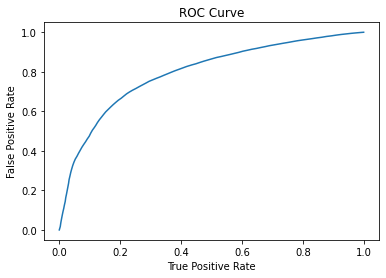

Training set areaUnderROC: 0.7943489965769207


In [58]:
trainingSummary = lr_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

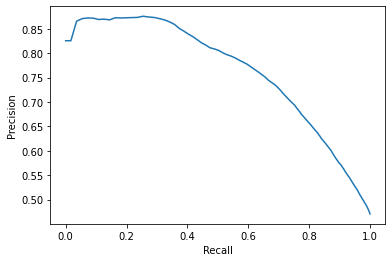

In [59]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#### LR Evaluation

In [60]:
evaluator_lr = MulticlassClassificationEvaluator(predictionCol="prediction")
acc_lr = evaluator_lr.evaluate(lr_prediction)
 
print("Prediction Accuracy: ", acc_lr)

Prediction Accuracy:  0.7304008791165


In [61]:
evaluator_roc = BinaryClassificationEvaluator()
print("LR - Test Area Under ROC: " + str(evaluator_roc.evaluate(lr_prediction, {evaluator_roc.metricName: "areaUnderROC"})))

LR - Test Area Under ROC: 0.7918602553204137


In [69]:
y_pred_lr = lr_prediction.select("prediction").collect()
y_orig_lr = lr_prediction.select("label").collect()

print(classification_report(y_orig_lr, y_pred_lr))


              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77      7352
         1.0       0.74      0.72      0.73      6518

    accuracy                           0.75     13870
   macro avg       0.75      0.75      0.75     13870
weighted avg       0.75      0.75      0.75     13870



### Decision Tree

In [75]:
#define the decision tree classifier model by using the DecisionTreeClassifier class 
#and fit model on train data. We can predict test data by using trasnform() method.

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 30)
dt_model = dt.fit(train)
dt_prediction = dt_model.transform(test)

dt_prediction.show(5)

+--------------------+-----+-------------+-----------+----------+
|            features|label|rawPrediction|probability|prediction|
+--------------------+-----+-------------+-----------+----------+
|[0.0,93.2,-42.0,4...|  0.0|    [2.0,0.0]|  [1.0,0.0]|       0.0|
|[1.0,92.893,-46.2...|  0.0|   [10.0,0.0]|  [1.0,0.0]|       0.0|
|[1.0,93.075,-47.1...|  0.0|    [7.0,0.0]|  [1.0,0.0]|       0.0|
|[1.0,93.2,-42.0,4...|  0.0|    [4.0,0.0]|  [1.0,0.0]|       0.0|
|[2.0,93.075,-47.1...|  0.0|   [0.0,15.0]|  [0.0,1.0]|       1.0|
+--------------------+-----+-------------+-----------+----------+
only showing top 5 rows



In [64]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(dt_prediction)
 
print("Prediction Accuracy: ", acc)
 
y_pred=dt_prediction.select("prediction").collect()
y_orig=dt_prediction.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)


Prediction Accuracy:  0.9021174345494256
Confusion Matrix:
[[6639  713]
 [ 645 5873]]


#### DT Evaluation

In [65]:
print("Prediction Accuracy: ", acc)

Prediction Accuracy:  0.9021174345494256


In [66]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(dt_prediction, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9438945607560013


In [67]:
print(classification_report(y_orig, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91      7352
         1.0       0.89      0.90      0.90      6518

    accuracy                           0.90     13870
   macro avg       0.90      0.90      0.90     13870
weighted avg       0.90      0.90      0.90     13870



### ROC Curve for LR and DT

In [74]:
# Need these function to plot ROC curve for DT since there is no training summary for DT

from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

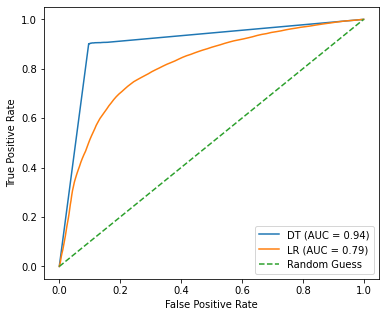

In [91]:
# ROC curves

preds = dt_prediction.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure(figsize=(6,5))
dt_x_val = [x[0] for x in points]
dt_y_val = [x[1] for x in points]

lr_trainingSummary = lr_model.summary
lr_roc = lr_trainingSummary.roc.toPandas()
lr_x_val = lr_roc['FPR']
lr_y_val = lr_roc['TPR']

random_x = [0,1]
random_y = [0,1]


plt.plot(dt_x_val, dt_y_val, label = 'DT (AUC = 0.94)')
plt.plot(lr_x_val, lr_y_val, label = 'LR (AUC = 0.79)')
plt.plot(random_x, random_y, label = 'Random Guess', linestyle="--")

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

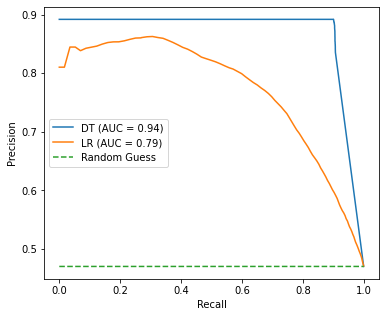

In [94]:
# Precision-Recall curves

points = CurveMetrics(preds).get_curve('pr')

plt.figure(figsize=(6,5))
dt_x_val = [x[0] for x in points]
dt_y_val = [x[1] for x in points]

pr = lr_trainingSummary.pr.toPandas()
lr_x_val = pr['recall']
lr_y_val = pr['precision']

random_x = [0, 1]
random_y = [0.4699, 0.46991]

plt.plot(dt_x_val, dt_y_val, label = 'DT (AUC = 0.94)')
plt.plot(lr_x_val, lr_y_val, label = 'LR (AUC = 0.79)')
plt.plot(random_x, random_y, label = 'Random Guess', linestyle="--")

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()
plt.show()